In [5]:
#Fill the paths below
PATH_FRC = "" # git repo directory path
PATH_ZENODO = "" # Data and models are available here: https://zenodo.org/record/5831014#.YdnW_VjMLeo

GAUSS_L2_MODEL = PATH_ZENODO+'/models/gaussian/noise04/l2/' # noise 0.4
DATA_TEST = PATH_ZENODO+'/data/goi_1000/test_50/*.jpg'

GAUSS_L2_MODEL_FLAT = PATH_ZENODO+'/models/gaussian/noise005_set1000/flat/' # noise 0.05
DATA_FLAT = PATH_ZENODO+'/data/goi_1000/flat_1000/*.png'

In [6]:
import sys
sys.path.append(PATH_FRC)

import glob
import os
import skimage
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import matplotlib

import tensorflow as tf
from models2 import FRCUnetModel
from skimage.filters import window
from tqdm import tqdm
import pandas as pd

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})

In [7]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))
      
def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    return frc  

def add_noise(im):
    noise1=np.random.normal(0,0.4,256**2*50).reshape(50,256,256)
    return im.copy() + noise1

# Averaging

In [8]:
cleans_mean=[]
for file in sorted(glob.glob(DATA_TEST+'/*')):
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    
    clean=tf.convert_to_tensor(clean)
    clean=clean[tf.newaxis, ..., tf.newaxis]

    clean=tf.image.resize(
    clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True, antialias=False, name=None)
    clean=clean.numpy().squeeze()
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    clean = clean*window('hann', clean.shape) #window('hann', clean.shape)
    cleans_mean.append(clean)
    
cleans_mean=np.stack(cleans_mean)
cleans_mean=cleans_mean[:50,:,:]

In [9]:
l2_model=load_model(GAUSS_L2_MODEL, 'saved-model-epoch-200')

In [10]:
noise_evaluations=[]
for i in range(200):
    noise_evaluations.append(add_noise(cleans_mean))  
    
noise_evaluations=np.array(noise_evaluations)

In [11]:
noisy_clean=[]
for i in range(50):
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_mean[i], [1,256, 256,1]), np.reshape(noise_evaluations[0][i], [1,256, 256,1]), 
                                         l2_model.radial_masks, l2_model.spatial_freq)
    noisy_clean.append(frc.numpy().T[0])
    
noisy_clean_raw=np.stack(noisy_clean)
noisy_clean=noisy_clean_raw.mean(axis=0)

In [12]:
mean_noisy= noise_evaluations.mean(axis=0)
mean_clean=[]
for i in range(50):
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_mean[i], [1,256, 256,1]), np.reshape(mean_noisy[i], [1,256, 256,1]), 
                                         l2_model.radial_masks, l2_model.spatial_freq)
    mean_clean.append(frc.numpy().T[0])
    
mean_clean_raw=np.stack(mean_clean)
mean_clean=mean_clean_raw.mean(axis=0)

In [13]:
denoised_n2n=[]
for i in range(50):
    
    denoised = l2_model.model(np.reshape(noise_evaluations[0][i], [1,256, 256,1]))
    denoised = np.squeeze(denoised)
    
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_mean[i], [1,256, 256,1]), np.reshape(denoised, [1,256, 256,1]), 
                                         l2_model.radial_masks, l2_model.spatial_freq)
    denoised_n2n.append(frc.numpy().T[0])
    
denoised_n2n_raw = np.stack(denoised_n2n)
denoised_n2n = denoised_n2n_raw.mean(axis=0)

In [14]:
denoised_evaluations=[]
for j in tqdm(range(200)):
    batch=[]
    for i in range(50):
        denoised = l2_model.model(np.reshape(noise_evaluations[j][i], [1,256, 256,1]))
        denoised = np.squeeze(denoised)
        batch.append(denoised)
    denoised_evaluations.append(batch)

100%|██████████| 200/200 [24:39<00:00,  7.40s/it]


In [15]:
denoised_evaluations=np.array(denoised_evaluations)
mean_denoised = denoised_evaluations.mean(axis=0)
mean_denoised_clean=[]
for i in range(50):
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_mean[i], [1,256, 256,1]), np.reshape(mean_denoised[i], [1,256, 256,1]), 
                                         l2_model.radial_masks, l2_model.spatial_freq)
    mean_denoised_clean.append(frc.numpy().T[0])
    
mean_denoised_clean_raw=np.stack(mean_denoised_clean)
mean_denoised_clean=mean_denoised_clean_raw.mean(axis=0)

In [16]:
data_mean=pd.DataFrame([noisy_clean, denoised_n2n, mean_clean, mean_denoised_clean ]).T
data_mean.columns=['Noisy-GT', 'N2N', 'MeanN-GT',  'MeanD-GT' ]

# Frequency Bias

In [17]:
l2_1000_model_flat=load_model(GAUSS_L2_MODEL_FLAT, 'saved-model-epoch-200')

In [18]:
files_flat=sorted(glob.glob(DATA_FLAT))
files_flat=files_flat[:50]

In [19]:
cleans_flat=[]
for file in files_flat:
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    clean = clean*window('hann', clean.shape)
    cleans_flat.append(clean)
cleans_flat=np.stack(cleans_flat)
cleans_flat.shape

(50, 256, 256)

In [20]:
noise=np.random.normal(0,0.05,256**2*50).reshape(50,256,256)
noisy_flat=cleans_flat.copy()+noise

In [21]:
noisy_clean_flat=[]
for i in range(50):
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_flat[i], [1,256, 256,1]), np.reshape(noisy_flat[i], [1,256, 256,1]), 
                                         l2_1000_model_flat.radial_masks, l2_1000_model_flat.spatial_freq)
    noisy_clean_flat.append(frc.numpy().T[0])
    
noisy_clean_flat_raw=np.stack(noisy_clean_flat)
noisy_clean_flat=noisy_clean_flat_raw.mean(axis=0)

In [22]:
denoised_flat=[]
for i in range(50):
    
    denoised = l2_1000_model_flat.model(np.reshape(noisy_flat[i], [1,256, 256,1]))
    denoised = np.squeeze(denoised)
    
    frc = fourier_ring_correlation_by_ring(np.reshape(cleans_flat[i], [1,256, 256,1]), np.reshape(denoised, [1,256, 256,1]), 
                                         l2_1000_model_flat.radial_masks, l2_1000_model_flat.spatial_freq)
    denoised_flat.append(frc.numpy().T[0])
    
denoised_flat_raw=np.stack(denoised_flat)
denoised_flat=denoised_flat_raw.mean(axis=0)

In [23]:
data_flat=pd.DataFrame([noisy_clean_flat, denoised_flat]).T
data_flat.columns=['Noisy-GT-flat', 'N2N-flat' ]

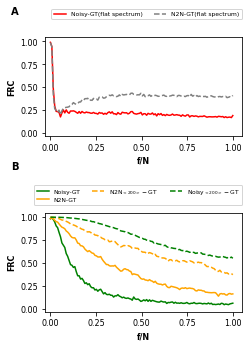

In [24]:
fig = plt.figure()
fig.set_size_inches(3.5, 5)#(3.5, 5.9) # 3.5 inch is the width of one column in A4 paper 

##Subplot 1 
ax = fig.add_subplot(211)

plt.gcf().text(0.05, 0.93, 'A', fontsize=10,weight = 'bold')
legend_properties = { 'size':6}

ax.plot(data_flat.index/data_flat.index.max(),data_flat['Noisy-GT-flat'] , label='Noisy-GT(flat spectrum)', lw=1.5, c='red')
ax.plot(data_flat.index/data_flat.index.max(),data_flat['N2N-flat'] , label='N2N-GT(flat spectrum)', lw=1.5, c='gray', ls='dashed')

ax.set_xlabel('f/N')
ax.set_ylabel('FRC')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.ylim([-0.03,1.05])
plt.xlim([-0.03,1.05])

ax.legend(prop=legend_properties, loc=1, ncol=3, bbox_to_anchor=(1.015, 1.31) )
fig.tight_layout()

##Subplot 2
ax = fig.add_subplot(212)

plt.gcf().text(0.05, 0.5, 'B', fontsize=10,weight = 'bold')

legend_properties = { 'size':6}

ax.plot(data_mean.index/data_mean.index.max(),data_mean['Noisy-GT'] , label='Noisy-GT', lw=1.5, c='green')
ax.plot(data_mean.index/data_mean.index.max(),data_mean['N2N'] , label='N2N-GT', lw=1.5, c='orange')
ax.plot(data_mean.index/data_mean.index.max(),data_mean['MeanD-GT'] , label=r'$N2N_{<200>}-GT$', lw=1.5, c='orange', ls='dashed')
ax.plot(data_mean.index/data_mean.index.max(),data_mean['MeanN-GT'] , label=r'$Noisy_{<200>}-GT$', lw=1.5, c='green', ls='dashed')

ax.set_xlabel('f/N')
ax.set_ylabel('FRC')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.ylim([-0.03,1.05])
plt.xlim([-0.03,1.05])

ax.legend(prop=legend_properties, loc=1, ncol=3, bbox_to_anchor=(1.015, 1.31) )

fig.tight_layout()
fig.savefig('figure_s4.png', dpi=300) # dpi 300-200 